In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# ---------------------------
# 1. Load and Combine Datasets
# ---------------------------
train_df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/train.csv")
dev_df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/dev.csv")
df = pd.concat([train_df, dev_df], ignore_index=True)
df

,id,text,label
0,3268,Indha ariya kandupidippin moolam neenga solla ...,0
1,6239,@vijayakumarp7959 unmai therincha nee pesu,0
2,5859,Inga erukka yella dev... boys vadakkan vadakk...,1
3,3519,பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த 350 கோடியை ...,1
4,5136,Mumbai Bangalore la 80% percentage outsiders,1
...,...,...,...
6294,5860,This is done by those who want chaos in Tamil ...,0
6295,1441,"வடமாநிலத்தவருக்கு வேலை வாய்ப்பு கொடுப்பதை ,பணி...",0
6296,3253,நம்ம மேல எந்த தப்பும் இல்லை.... ஏன் என்றால் நா...,0
6297,4295,தம்பி உத்திரபிரதேசம் டெல்லி எல்லையில் உள்ள 90%...,1


In [5]:
df["label"].value_counts()

label
0    3900
1    2399
Name: count, dtype: int64

In [10]:
tamil_stopwords = set(stopwords.words('tamil'))
english_stopwords = set(stopwords.words('english'))

In [11]:
# -------------------------------
# Text Preprocessing
# -------------------------------
def clean_text(text):
    text = str(text).lower()
    text = emoji.replace_emoji(text, replace='')                           # remove emojis
    text = re.sub(r"http\S+|www\S+", "", text)                             # remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)                                  # remove mentions and hashtags
    text = re.sub(r"\d+", "", text)                                       # remove numbers
    text = re.sub(r"[^\w\sஅ-ஹா-௺]", " ", text)                            # keep Tamil + Tanglish
    text = re.sub(r"\s+", " ", text).strip()                              # normalize whitespace
    return text

def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word not in english_stopwords and word not in tamil_stopwords]
    return ' '.join(filtered)

# Apply preprocessing
df['text'] = df['text'].apply(clean_text).apply(remove_stopwords)
df

,id,text,label
0,3268,indha ariya kandupidippin moolam neenga solla ...,0
1,6239,unmai therincha nee pesu,0
2,5859,inga erukka yella dev boys vadakkan vadakkan s...,1
3,3519,பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த கோடியை எப்ப...,1
4,5136,mumbai bangalore la percentage outsiders,1
...,...,...,...
6294,5860,done want chaos tamil nadu make people states ...,0
6295,1441,வடமாநிலத்தவருக்கு வேலை வாய்ப்பு கொடுப்பதை பணிய...,0
6296,3253,நம்ம மேல தப்பும் இல்லை என்றால் நாம ஜாதி மதம் ன...,0
6297,4295,தம்பி உத்திரபிரதேசம் டெல்லி எல்லையில் கம்பெனிக...,1


In [12]:
# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

In [13]:
# -------------------------------
# TF-IDF Vectorization (optimized for multilingual text)
# -------------------------------
vectorizer = TfidfVectorizer(
    max_features=7000,
    ngram_range=(1,2),
    analyzer='word',
    token_pattern=r"(?u)\b\w+\b"
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [26]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

ensemble_models = {
    "Voting Classifier (Hard)": VotingClassifier(estimators=base_estimators, voting='hard'),
    "Voting Classifier (Soft)": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, solver='liblinear')), 
            ('rf', RandomForestClassifier()),
            ('gb', GradientBoostingClassifier())
        ],
        voting='soft'
    ),
    "Stacking Classifier": StackingClassifier(
        estimators=base_estimators,
        final_estimator=LogisticRegression(solver='liblinear')
    )
}

non_ensemble_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Combine both lists into a single dictionary for easier processing
models = {**ensemble_models, **non_ensemble_models}

Training Models:   0%|          | 0/11 [00:00<?, ?it/s]


Training: Voting Classifier (Hard)


Training Models:   9%|▉         | 1/11 [00:05<00:54,  5.42s/it]


Training: Voting Classifier (Soft)


Training Models:  18%|█▊        | 2/11 [00:16<01:16,  8.46s/it]


Training: Stacking Classifier


Training Models:  27%|██▋       | 3/11 [00:42<02:14, 16.79s/it]


Training: Logistic Regression


Training Models:  36%|███▋      | 4/11 [00:42<01:11, 10.25s/it]


Training: Naive Bayes


Training Models:  45%|████▌     | 5/11 [00:43<00:39,  6.63s/it]


Training: Linear SVM


Training Models:  55%|█████▍    | 6/11 [00:43<00:22,  4.47s/it]


Training: Decision Tree


Training Models:  64%|██████▎   | 7/11 [00:45<00:14,  3.54s/it]


Training: Random Forest


Training Models:  73%|███████▎  | 8/11 [00:50<00:12,  4.15s/it]


Training: Gradient Boosting


Training Models:  82%|████████▏ | 9/11 [00:56<00:09,  4.65s/it]


Training: AdaBoost


Training Models:  91%|█████████ | 10/11 [00:58<00:03,  3.83s/it]


Training: XGBoost


Training Models: 100%|██████████| 11/11 [01:02<00:00,  5.70s/it]


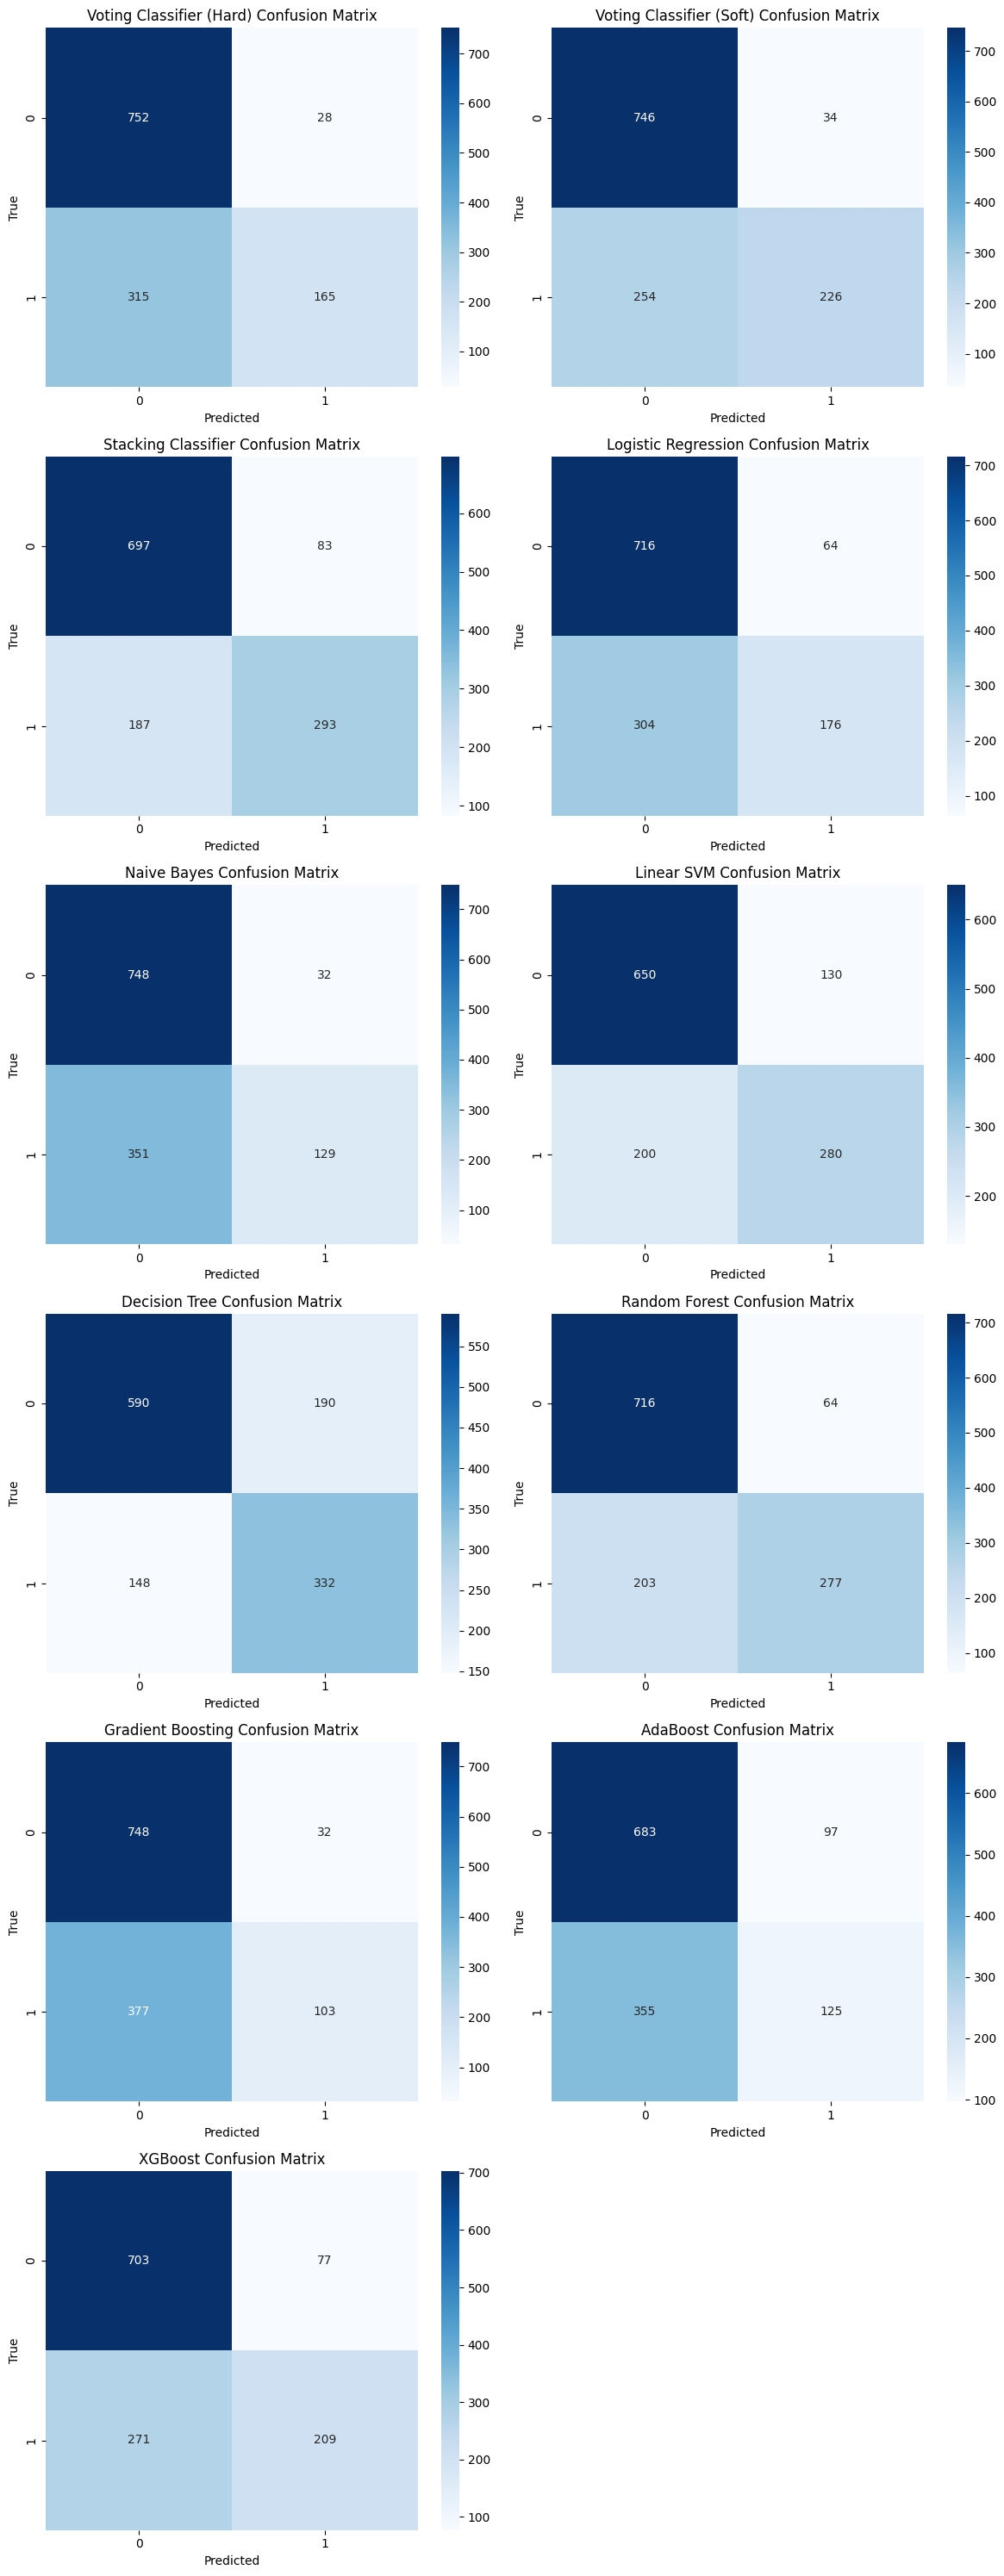

In [31]:
# -------------------------------
# Train & Evaluate (with tqdm and updated subplots)
# -------------------------------
results = []

# Adjust the number of rows and columns based on the number of models
n_models = len(models)
n_cols = 2  # For example, 2 columns
n_rows = (n_models + n_cols - 1) // n_cols  # Calculate required rows

plt.figure(figsize=(12, 5 * n_rows))  # Adjust figure size based on rows

for idx, (model_name, model) in enumerate(tqdm(models.items(), desc="Training Models", total=n_models)):
    print(f"\nTraining: {model_name}")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    results.append((model_name, acc, f1))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(n_rows, n_cols, idx + 1)  # Update subplot position
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()

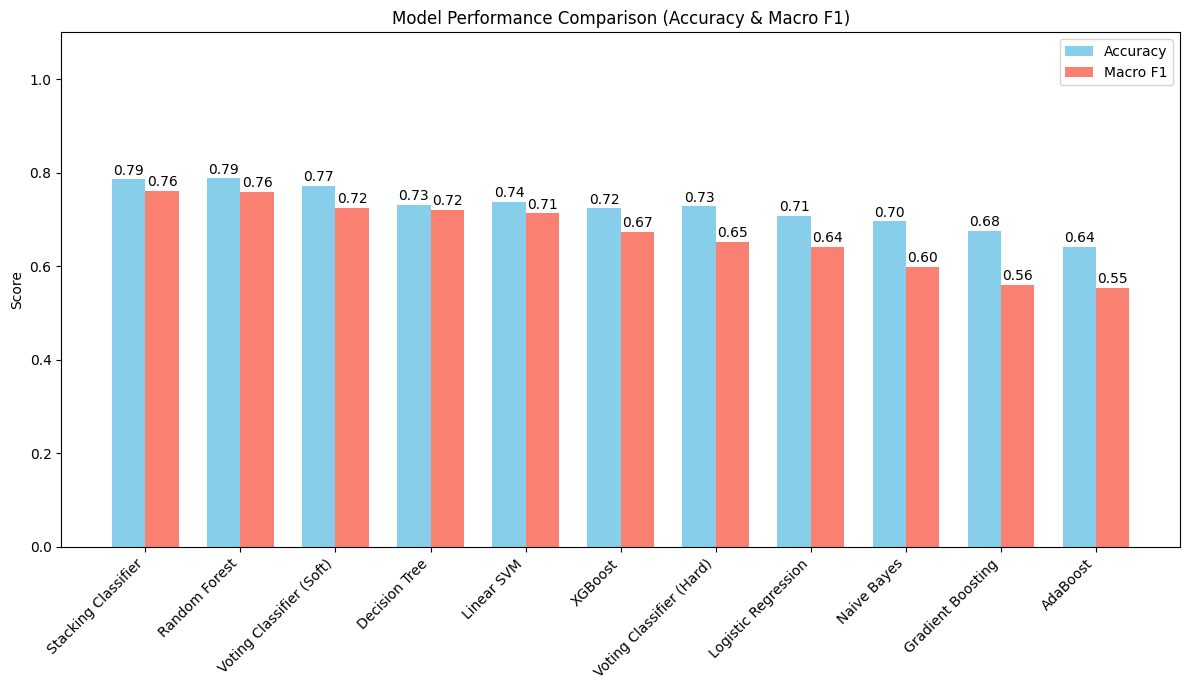

In [32]:
# -------------------------------
# Accuracy & F1 Score Plot (with value annotations)
# -------------------------------
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro F1"])
results_df = results_df.sort_values(by="Macro F1", ascending=False)

plt.figure(figsize=(12, 7))
bar_width = 0.35
x = np.arange(len(results_df))

# Plot bars
bars1 = plt.bar(x - bar_width/2, results_df["Accuracy"], bar_width, label='Accuracy', color='skyblue')
bars2 = plt.bar(x + bar_width/2, results_df["Macro F1"], bar_width, label='Macro F1', color='salmon')

# Annotate values on top of bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', fontsize=10)

# Final touches
plt.xticks(x, results_df["Model"], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Model Performance Comparison (Accuracy & Macro F1)")
plt.ylim(0, 1.1)  # Optional: Keep a little space above bars for annotations
plt.legend()
plt.tight_layout()
plt.show()
